we will work with classification algorithms. We'll start again by loading some of the needed libraries.

Note that comments in the coding exercise cells below just serve as hints and are not requirements for your own code.

In [1]:
# plt to plot figures
import matplotlib.pyplot as plt
# numpy for array/matrix operations
import numpy as np
# to be able to load matlab data files
from scipy.io import loadmat

# we set a seed variable for functions that use randomization (e.g. when shuffling data samples)
# this way, we can have reproducible results even with randomization
RANDOM_STATE = 2

## 1) Support Vector Machines


### 1.1) Linearly separable datasets

The first thing we're going to do is look at a simple 2-dimensional data set and see how a linear SVM works on this data. Let's load the data and visualize it as a scatter plot where the class label is denoted by a symbol ('+' for positive, 'o' for negative).


#### Use PCA to transform your data and project it to a 2-dimensional space. Visualize the result as a scatter plot.

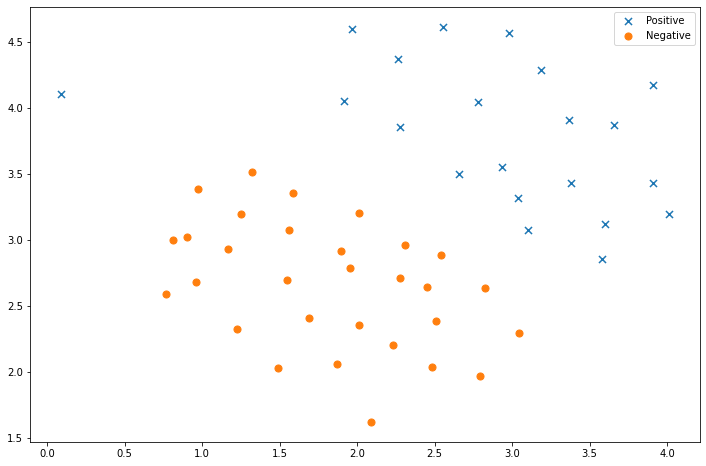

In [2]:
raw_data = loadmat('ex3data1.mat')
X, y = raw_data['X'], np.squeeze(raw_data['y'], axis=1)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[np.where(y==1)[0],0],X[np.where(y==1)[0],1], s=50, marker='x', label='Positive')
ax.scatter(X[np.where(y==0)[0],0],X[np.where(y==0)[0],1], s=50, marker='o', label='Negative')

ax.legend()

#### Observation

Notice that there is one outlier positive example that sits apart from the others. The classes are still linearly separable but it's a very tight fit. We're going to train a linear support vector machine to learn the class boundary.

*Quick note about why we need feature scaling / z-normalization of input features:*
Feature scaling is mapping the feature values of a dataset into the same range. Feature scaling is crucial for some machine learning algorithms, which consider distances between observations because the distance between two observations differs for non-scaled and scaled cases.
As we know from the lecture, in SVMs, the decision boundary maximizes the distance to the nearest data points from different classes. Hence, the distance between data points affects the decision boundary SVM chooses. In other words, training an SVM over the scaled and non-scaled data can lead to generation of different models.

#### Train and evaluate a linear SVM for this dataset (train and evaluate on the same data; use z-normalization).

In [3]:
RANDOM_STATE = 2
np.random.seed(RANDOM_STATE)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# load linear SVM algorithm
from sklearn.svm import LinearSVC

# z-normalization
scaler = StandardScaler()
scaler.fit(X)
X_st = scaler.transform(X)

# train and classify with LinearSVC
svm = LinearSVC(random_state=RANDOM_STATE, C=1.0)
svm.fit(X_st, y)
output = svm.predict(X_st)
acc = accuracy_score(y, output)

result = svm.score(X_st, y)

print(result)
print(acc)


0.9803921568627451
0.9803921568627451


### 1.2) SVM regularization parameter C

The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words C behaves as a regularization parameter in the SVM.

Let's take a look at the effects of parameter C on the decision hyperplane, support vectors and accuracy. 


####  Train two linear SVM with two values for C (0.5 and 100). Plot the resulting decision boundaries, margins and the support vectors for each resulting SVM.

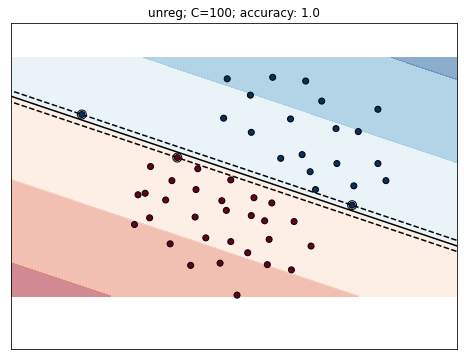

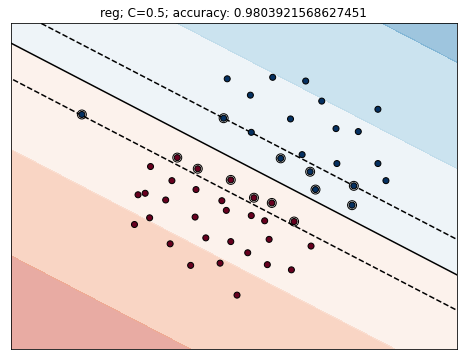

In [4]:
from matplotlib import cm
# note: we need to use SVC class here because LinearSVC doesn't have certain attributes that are 
# needed for plotting
from sklearn.svm import SVC

fignum=1

for name, C_value in (("unreg", 100), ("reg", 0.5)):

    # instantiate and fit SVM with C_value
    svm = SVC(kernel="linear", C=C_value)
    svm.fit(X_st, y)
    acc = svm.score(X_st, y)
    
    # get the separating hyperplane
    w = svm.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (svm.intercept_[0]) / w[1]

    # plot the parallels to the separating hyperplane that pass through the
    # support vectors (margin away from hyperplane in direction
    # perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
    # 2-d.
    margin = 1 / np.sqrt(np.sum(svm.coef_ ** 2))
    yy_down = yy - np.sqrt(1 + a ** 2) * margin
    yy_up = yy + np.sqrt(1 + a ** 2) * margin

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(8, 6))
    plt.clf()
    plt.plot(xx, yy, "k-")
    plt.plot(xx, yy_down, "k--")
    plt.plot(xx, yy_up, "k--")

    # mark the support vectors in the plot
    plt.scatter(
        # YOUR CODE HERE, TWO ARGUMENTS: all x and y coordinates of support vectors (accessible as attributes in a trained svm, see doc)
        svm.support_vectors_[:, 0],
        svm.support_vectors_[:, 1],
        s=80,
        facecolors="none",
        zorder=10,
        edgecolors="k",
        cmap=cm.get_cmap("RdBu"),
    )
    
    # plot all data points
    plt.scatter(
        # YOUR CODE HERE, THREE ARGUMENTS: all x and y coordinates of data points and their color (=class)
        X_st[:, 0], X_st[:, 1], c=y, 
        zorder=10, cmap=cm.get_cmap("RdBu"), edgecolors="k"
    )

    plt.axis("tight")
    
    # set range of axes for your data points
    x_min = np.min(X_st[:,0])-1
    x_max = np.max(X_st[:,0])+1 
    y_min = np.min(X_st[:,1])-1
    y_max = np.max(X_st[:,1])+1

    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = svm.decision_function(xy).reshape(XX.shape)

    # Put the result into a contour plot
    plt.contourf(XX, YY, Z, cmap=cm.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    plt.title("; ".join([name, "C=" + str(C_value), "accuracy: " + str(acc)]))
    
    fignum = fignum + 1


#### Observation

We should be able to see that low regularization (i.e. high C) results in perfect classification of the training data, however by increasing the value of C we've created a decision boundary that is not necessarily a natural fit for the data. This will become apparent when classifying new data points (but we won't do that here now).

### 1.3) Non-linearly separable datasets

In practice, we will often find that our dataset is not linearly separable and a linear classifier will not be able to perform well on it. Let's take a look at the dataset below. 

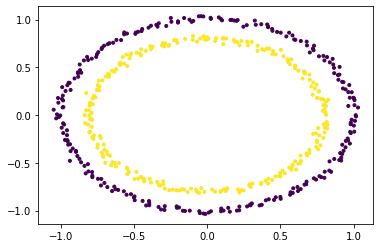

In [5]:
from sklearn.datasets import make_circles
#from mpl_toolkits.mplot3d import Axes3D

# generating data
X, y = make_circles(n_samples = 500, noise = 0.02, random_state=RANDOM_STATE)
  
# visualizing data
plt.scatter(X[:, 0], X[:, 1], c = y, marker = '.')
plt.show()

#### Observation

This dataset is clearly a non-linear dataset (classes cannot be separated by a straight line) and consists of two features (say, A and B). A linear classifier cannot separate the two classes in this dataset as is. To get further evidence for this conclusion (which in practice is rarely as obvious as in this 2-D case), let's first try our linear SVM on this dataset.

#### Run training and classification using a *linear* SVM classifier (use a 80/20% train/test split). Hint: Feel free to copy your code from above.

In [6]:
RANDOM_STATE = 2
np.random.seed(RANDOM_STATE)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# load linear SVM algorithm
from sklearn.svm import LinearSVC

# create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=True, random_state=RANDOM_STATE)

# z-normalization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# train and classify with LinearSVC
svm = LinearSVC(random_state=RANDOM_STATE, C=1.0)
svm.fit(X_train_st, y_train)
output = svm.predict(X_test_st)
acc = accuracy_score(y_test, output)

result = svm.score(X_test_st, y_test)

print(result)
print(acc)

0.48
0.48


#### Observation

Results above should show that a linear SVM doesn't work much better than chance level on this dataset, further solidifying our initial impression, that the dataset is not linearly separable. So, we conclude now that a linear SVM, which is a linear classifier, cannot separate the two classes in this dataset. But, we can use SVM's Kernel trick to project this dataset into a higher dimensionality where the classes become separable. We'll use the popular Gaussian Kernel ("RBF - radial basis function") for this.

Let's first recap what an RBF is by implementing the function from scratch based on the formula from the lecture:

Gaussian Kernel $k(x,y) = exp(\frac{-||x-y||^2}{2\sigma^2})$

#### Implement a gaussian kernel function, also called the "radial basis function" (formula e.g. in the lecture). You can validate it with the given parameters/result.

In [7]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(-(np.sum((x1 - x2) ** 2) / (2 * (sigma ** 2))))
    #return np.exp(-gamma * (np.sum((x1 - x2) ** 2)))


#### code for verifying gaussian_kernel function below, no need to change
# sample parameter values
x1 = np.array([1.0, 2.0, 1.0])
x2 = np.array([0.0, 4.0, -1.0])
sigma = 2
#gamma = 1/(2 * (sigma ** 2))
#print(gaussian_kernel(x1, x2, sigma)) 
result = gaussian_kernel(x1, x2, sigma)
expected_result = 0.32465246735834974
if expected_result == result: 
    print("Correct!")
else:
    print("Somthing went wrong.")
    print("Your result: ", result)
    print("Expected result: ", expected_result)

Correct!


### 1.4) SVM with RBF Kernel

Now that we gained some insight about what the RBF looks like, let's train an SVM with RBF Kernel for our dataset. We can use the already implemented RBF in sklearn for this.

#### Run training and classification using an SVM classifier with RBF kernel. Confirm that accuracy is now much better.


In [8]:
RANDOM_STATE = 2
np.random.seed(RANDOM_STATE)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# load SVM algorithm
from sklearn.svm import SVC

# train and classify with SVC with RBF kernel
svm = SVC(kernel='rbf', random_state=RANDOM_STATE, C=1.0)
svm.fit(X_train_st, y_train)
output = svm.predict(X_test_st)
acc = accuracy_score(y_test, output)

result = svm.score(X_test_st, y_test)

print(result)
print(acc)

1.0
1.0


### 1.5) Parameter Tuning of an SVM with RBF Kernel

Note that the RBF is often implemented as:

$k(x,y) = exp(-\gamma||x-y||^2)$

with $\gamma = \frac{1}{2\sigma^2}$

Here, $\gamma$ (gamma) becomes a tuning parameter in SVM training. When training an SVM with the Radial Basis Function (RBF) kernel (which is usually used for non-linearly separable datasets), two parameters must be considered: C (already discussed above) and gamma. 

Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

Let's do this tuning of both C and gamma now by running a logarithmic grid search over various combinations. The best parameter combination is to be determined based on the performance on a *validation* set.

*Note on validation set:* 
A validation dataset is a subset of data held back from training your model that is used to give an estimate of model skill while tuning a model's hyperparameters (like C and gamme in our case here).
The validation dataset is different from the test dataset which is also held back from the training of the model, but is instead used to give an unbiased estimate of the skill of the final tuned model.

*Note on (logarithmic) grid search:*
A grid search (here in the context of tuning a classifier) is a search over various combinations of hyper-parameter ranges. Often hyper-parameter values can be chosen that are spaced apart based on a logarithmic scale (i.e. 0.1, 1, 10, 100, ...), which allows for a faster search over a larger parameter space. Further refinements (smaller valued steps) can then be made in the ranges that show the most promise (based on validation set performance).

We'll introduce a new dataset for this task, which we first load and visualize below.

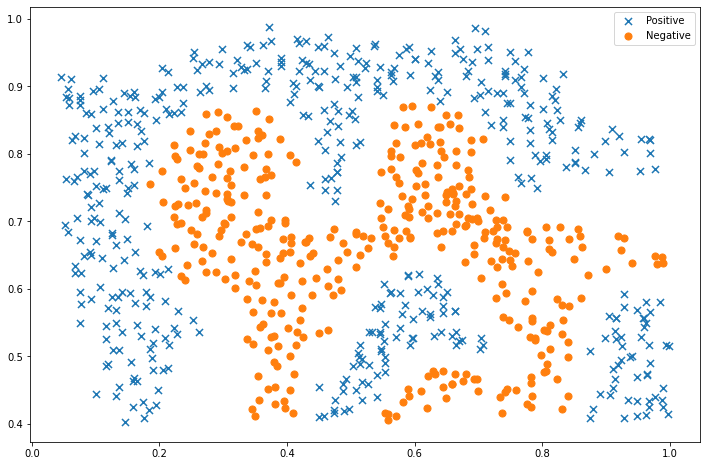

In [9]:
### Load new dataset

# Let's load and preprocess the data first
raw_data = loadmat('ex3data2.mat')
X_all,y_all = raw_data['X'], np.squeeze(raw_data['y'], axis=1)

# visualize the data
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X_all[np.where(y_all==1)[0],0],X_all[np.where(y_all==1)[0],1], s=50, marker='x', label='Positive')
ax.scatter(X_all[np.where(y_all==0)[0],0],X_all[np.where(y_all==0)[0],1], s=50, marker='o', label='Negative')
ax.legend()


### Data prep

As a preprocessing step for classifier training, let's create train/val/test data splits and z-normalize the data.

####  Create train/test set splits (80/20%). Then create train/val by taking 10% from train. Finally z-normalize all three data sets.

In [10]:
# for comparison/reproducibility 
RANDOM_STATE = 2
np.random.seed(RANDOM_STATE)

# create train/val/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.20, shuffle=True, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, shuffle=True, random_state=RANDOM_STATE)

# z-normalization of all datasets
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_val_st = scaler.transform(X_val)
X_test_st = scaler.transform(X_test)

#### Implement and run a logarithmic grid search over the given values for C and gamma by training an SVM (with RBF) for each (C,gamma) combination on the train set and evaluating them on the validation set. Determine the best performing (C,gamma) combination on the validation set. 

In [11]:
# We use logarithmic scale for the values of C/gamma to search a bigger space more quickly 
# Also, hyper-parameters might not be very sensitive to small changes
C_values = [0.1, 0.3, 1, 3, 10, 30, 100]
gamma_values = [0.1, 0.3, 1, 3, 10, 30, 100]

best_score = 0
best_params = {'C': None, 'gamma': None}
iteration = 0

for C in C_values:
    for gamma in gamma_values:
        iteration += 1 
        svc = SVC(kernel='rbf', C=C, gamma=gamma)
        svc.fit(X_train_st, y_train)
        score = svc.score(X_val_st, y_val)
        
        if score > best_score:
            best_score = score
            best_params['C'] = C
            best_params['gamma'] = gamma

        print("Iteration {}\nC: {}\ngamma: {}\n".format(iteration, C, gamma, score, best_params))

        
print("Best validation accuracy: {}\nBest parameters: {}".format(best_score, best_params))



Iteration 1
C: 0.1
gamma: 0.1

Iteration 2
C: 0.1
gamma: 0.3

Iteration 3
C: 0.1
gamma: 1

Iteration 4
C: 0.1
gamma: 3

Iteration 5
C: 0.1
gamma: 10

Iteration 6
C: 0.1
gamma: 30

Iteration 7
C: 0.1
gamma: 100

Iteration 8
C: 0.3
gamma: 0.1

Iteration 9
C: 0.3
gamma: 0.3

Iteration 10
C: 0.3
gamma: 1

Iteration 11
C: 0.3
gamma: 3

Iteration 12
C: 0.3
gamma: 10

Iteration 13
C: 0.3
gamma: 30

Iteration 14
C: 0.3
gamma: 100

Iteration 15
C: 1
gamma: 0.1

Iteration 16
C: 1
gamma: 0.3

Iteration 17
C: 1
gamma: 1

Iteration 18
C: 1
gamma: 3

Iteration 19
C: 1
gamma: 10

Iteration 20
C: 1
gamma: 30

Iteration 21
C: 1
gamma: 100

Iteration 22
C: 3
gamma: 0.1

Iteration 23
C: 3
gamma: 0.3

Iteration 24
C: 3
gamma: 1

Iteration 25
C: 3
gamma: 3

Iteration 26
C: 3
gamma: 10

Iteration 27
C: 3
gamma: 30

Iteration 28
C: 3
gamma: 100

Iteration 29
C: 10
gamma: 0.1

Iteration 30
C: 10
gamma: 0.3

Iteration 31
C: 10
gamma: 1

Iteration 32
C: 10
gamma: 3

Iteration 33
C: 10
gamma: 10

Iteration 34
C:

In [12]:
# train and evaluate on test set: SVM (RBF) with best parameters

svc = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
#svc = SVC(kernel='rbf', C=1, gamma=10)

svc.fit(X_train_st, y_train)

score_train = svc.score(X_train_st, y_train)
print("Train accuracy: ", score_train)

score_val = svc.score(X_val_st, y_val)
print("Validation accuracy: ", score_val)

score_test = svc.score(X_test_st, y_test)
print("Test accuracy: ", score_test)

Train accuracy:  0.9951690821256038
Validation accuracy:  1.0
Test accuracy:  0.9884393063583815


### 1.6) Comparison with other classifiers

Now we want to compare performance of various classifiers that we saw in the lecture. Let's train them and compare results. Use the dataset splits from above for this (train and test set only).

####  Run training and classification using the following classifiers: kNN, LDA, Decision Tree, *linear* SVM, SVM with RBF (using the best C,gamma combo from above)

Based on the results, can you tell which classifier is linear and which is non-linear? Do the results match your expectations?

kNN  0.9884393063583815
LDA  0.5433526011560693
SVM (linear) 0.5491329479768786
SVM (w/ RBF) 0.9884393063583815
D-Tree  0.9884393063583815
Chance:  0.5433526011560693


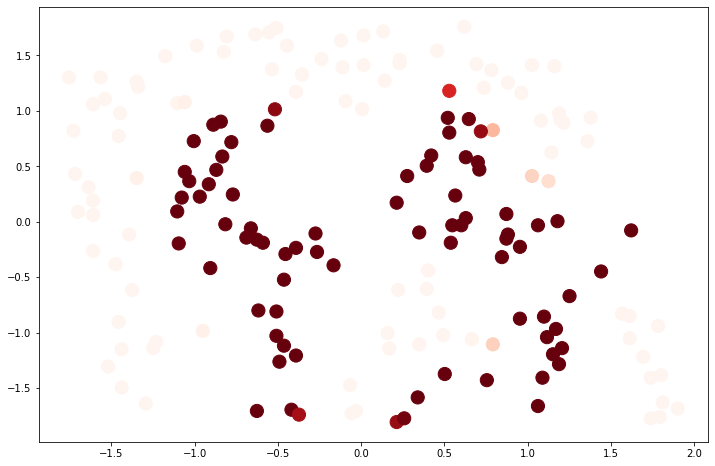

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

RANDOM_STATE = 2
np.random.seed(RANDOM_STATE)

# kNN
knn = KNeighborsClassifier()
knn.fit(X_train_st, y_train)
output = knn.predict(X_test_st)
acc = accuracy_score(y_test, output)
print("kNN ", acc)

# LDA
lda = LinearDiscriminantAnalysis()
lda_data = lda.fit_transform(X_train_st, y_train)
output = lda.predict(X_test_st)

acc = accuracy_score(y_test, output)
print("LDA ", acc)

# linear SVM
svm = LinearSVC(C=3)#, gamma=10)
svm.fit(X_train_st, y_train)
output = svm.predict(X_test_st)

acc = accuracy_score(y_test, output)
print("SVM (linear)", acc)

# SVM with RBF kernel and tuned C, gamma 
svm = SVC(kernel="rbf", probability=True, C=0.3, gamma=10)
svm.fit(X_train_st, y_train)
output = svm.predict(X_test_st)

acc = accuracy_score(y_test, output)
print("SVM (w/ RBF)", acc)

# SVM probabilities/distance to decision boundary
data = svm.predict_proba(X_test_st)[:,0]
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X_test_st[:,0], X_test_st[:,1], s=y_test.shape[0], c=data, cmap='Reds')

# decision tree
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X_train_st, y_train)
output = dtree.predict(X_test_st)
acc = accuracy_score(y_test, output)
print("D-Tree ", acc)

# compare with chance level
labels, counts = np.unique(y_test, return_counts=True)
chance_level = max(counts) / y_test.shape[0]
print("Chance: ", chance_level)


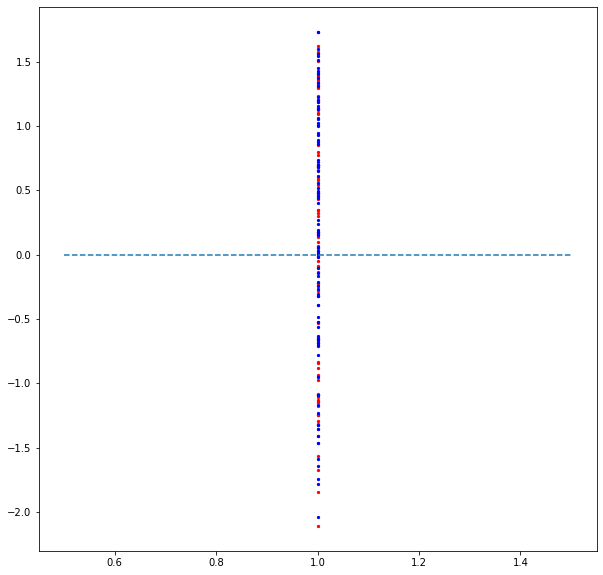

In [14]:
##### LDA Visualization
zeros = np.where(output==0)[0]
ones = np.where(output==1)[0]

plt.figure(figsize=(10,10))

plt.scatter(len(lda_data[zeros])*[1],lda_data[zeros],c="r",s=5)
plt.scatter(len(lda_data[ones])*[1],lda_data[ones],c="b",s=5)
plt.hlines(0,0.5,1.5,linestyle="--")

# Observation: LDA did not manage to find a 1 dimensional projection ((Nr_of_classes - 1)) that seperates the two classes.

## 2) Decision Trees

Decision Trees are a non-parametric supervised learning method used for classification (and regression). The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation. 
Let's take a look at the tree we created above. 


Tree depth:  10


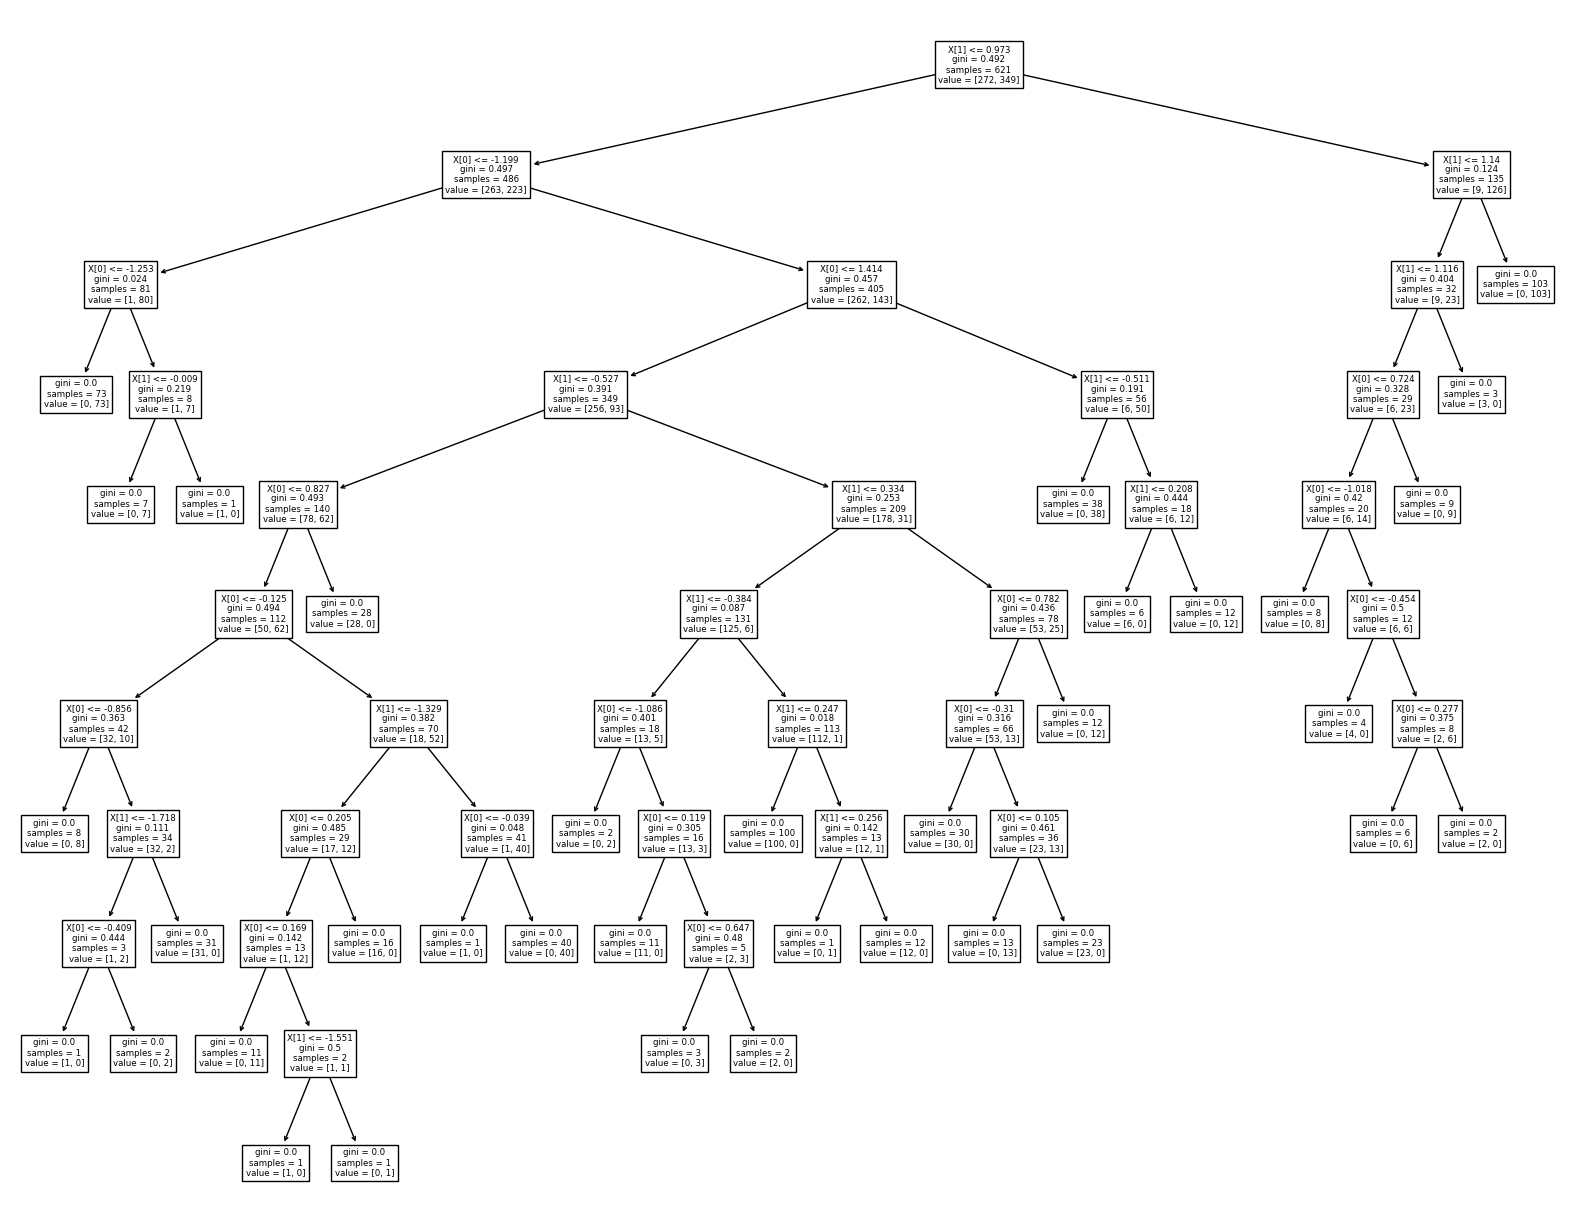

In [15]:
from sklearn import tree
plt.subplots(figsize=(20,16), dpi=100)
print("Tree depth: ", dtree.get_depth())
tree.plot_tree(dtree)
plt.show()

### Observation

This tree has a depth of 10, i.e. it can take up to 10 decisions before we arrive at a leaf node. Classification paths of this tree are determined based on the feature values of the input sample that we want to classify and the rules given in each node. 

Let the input sample that we want to classify with this tree be x=[0.62880647 0.03242455].

#### Determine the class of this data point and b) identify the leaf node in the tree that this decision is based on. (Hint: you can do this without coding by just looking at the tree.)

In [16]:
print("Data point:", X_test_st[0,:].reshape(-1,2))
#print("Decision path:\n", dtree.decision_path(X_test_st[0,:].reshape(-1,2)))

print("Predicted class:", dtree.predict(X_test_st[0,:].reshape(-1,2)))
print("Ground truth class:", y_test[0])

Data point: [[0.62880647 0.03242455]]
Predicted class: [0]
Ground truth class: 0


In [17]:
decision_path = dtree.decision_path(X_test_st[0,:].reshape(-1,2))
level_length = len(decision_path.indices)
i = 1
columns = ["Feature 0","Feature 1"]
print("Sample:",X_test_st[0,:])
for node_id in decision_path.indices:
  # Ignore last level because it is the last node
  # without decision criteria or rule
    if i < level_length:
        col_idx = dtree.tree_.feature[node_id]
        col_name = columns[int(col_idx)]
        threshold_value = dtree.tree_.threshold[node_id]
        rule = "{} <= {}".format(col_name, threshold_value)
        print("node#{}:".format(node_id), rule, X_test_st[0,:][col_idx], X_test_st[0,:][col_idx] <= threshold_value )
    i = i + 1

Sample: [0.62880647 0.03242455]
node#0: Feature 1 <= 0.9731282889842987 0.03242455477555398 True
node#1: Feature 0 <= -1.1988551616668701 0.6288064728451267 False
node#7: Feature 0 <= 1.4140225648880005 0.6288064728451267 True
node#8: Feature 1 <= -0.5274597704410553 0.03242455477555398 False
node#30: Feature 1 <= 0.33365432918071747 0.03242455477555398 True
node#31: Feature 1 <= -0.3840166926383972 0.03242455477555398 False
node#39: Feature 1 <= 0.24666496366262436 0.03242455477555398 True


1. Describe the training of a Decision Tree (Split Criterion,Termination Criterion).

The training of a decision tree aims to find the best split of the data such that the classes are seperated well, according to a split criterion (f.ex. Gini Impurity). A simple approach to find the best split looks at every feature value of every input sample and chooses the one that splits best, recursively for subsequent nodes. The training ends when no split of classes is possible anymore (no impurity) or a certain termination criterion is reached (tree depth, minimum number of samples...)

2. Name 3 good reasons for using a Decision Tree as a Machine Learning Model.

Various good reasons as mentioned in the lecture, in summary: Interpretability /graphical representation of prediction process, little preprocessing and no assumptions on data, fast prediction time.

3. Describe the data requirement and assumption for a classification with a Linear Discriminant Analysis (LDA) transform.

As LDA is a supervised algorithm, the label is needed for each data point. We assume that each class is normally distributed in the data feature space. 

4. What is the objective of the LDA transform and how do the nominator and denominator of the Fishers Ratio (J in the lecture) relate to it?

The objective of a LDA is to calculate a transformation of the data such that class discriminability is maximized according to the Fishers Ratio. Here, the nominator maximizes the ratio if the class distributions have a high difference in means (between-class scatter), while the denominator maximizes the term if an overall low variance is present for both classes (within-class scatter).

5. Describe the optimization criterion that is used to fit the dividing hyper plane for Support Vector Machines (SVM).

The optimization criterion for a SVM is the Maximim-Margin-Criterion. The goal is to find a dividing line(hyperplane) between classes that has the maximal distance to nearby data points of both classes. The closest samples to the diving line are called support vectors. The criterion aims to improve the generalizability of the classification.

6. How is non-linear separability achieved with SVMs and why do we need the kernel trick?

Non-linear seperability is achieved by using a non-linear transformation of the data into a higher dimensional feature space, where a linear seperability is possible. To enable a feasible calculation of the non-linear, higher dimensional transformation,  a non-linear kernel function like the Gaussian Kernel is needed to allow for a reformulation of the Maximum-Margin problem in terms of values of the kernel function. Combined with the sparsity contraint (only use support vectors), this allows for an efficient (possible!) calculation.